In [ ]:
import cv2
import mediapipe as mp
import numpy as np
import os
import glob
import csv
import shutil
import pandas as pd
from tqdm import tqdm
from collections import deque
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt


In [2]:
# Đường dẫn gốc dataset
dataset_root = r"C:\Users\admin\Documents\Học máy"

# Đường dẫn tới folder Train và Test
train_dir = os.path.join(dataset_root, "public_train1")
test_dir = os.path.join(dataset_root, "public_test")

print("Train folder:", train_dir)
print("Test folder:", test_dir)

# Lấy danh sách file trong từng folder
train_files = os.listdir(train_dir)
test_files = os.listdir(test_dir)

print(f"Tổng số file train: {len(train_files)}")
print(f"Tổng số file test: {len(test_files)}")

# Nếu muốn duyệt qua từng video trong Train
for video in train_files[:5]:  # In thử 5 video đầu
    print("Video train:", os.path.join(train_dir, video))


Train folder: C:\Users\admin\Documents\Học máy\public_train1
Test folder: C:\Users\admin\Documents\Học máy\public_test
Tổng số file train: 947
Tổng số file test: 60
Video train: C:\Users\admin\Documents\Học máy\public_train1\1.mp4
Video train: C:\Users\admin\Documents\Học máy\public_train1\10.mp4
Video train: C:\Users\admin\Documents\Học máy\public_train1\100.mp4
Video train: C:\Users\admin\Documents\Học máy\public_train1\1000.mp4
Video train: C:\Users\admin\Documents\Học máy\public_train1\101.mp4


In [ ]:
def split_videos_by_label(csv_path, video_dir, output_dir, seed=42):
    df = pd.read_csv(csv_path)

    # Xóa thư mục cũ (nếu có)
    if os.path.exists(output_dir):
        shutil.rmtree(output_dir)

    # ---- FIX 1: Loại bỏ NaN trong filename và label ----
    df = df.dropna(subset=['filename', 'label']).reset_index(drop=True)

    # ---- FIX 2: Chuẩn hóa label (tránh lỗi " 2", "3 ", "\t4") ----
    df['label'] = df['label'].astype(str).str.strip()

    # ---- FIX 3: Loại bỏ filename trùng ----
    if df['filename'].duplicated().sum() > 0:
        print("⚠ CSV có filename trùng → tự động loại bỏ các dòng trùng.")
        df = df.drop_duplicates(subset=['filename'])

    # ---- FIX 4: Loại bỏ lớp có < 2 mẫu vì stratify sẽ lỗi ----
    label_counts = df['label'].value_counts()
    small_classes = label_counts[label_counts < 2].index.tolist()

    if len(small_classes) > 0:
        print("⚠ Phát hiện class quá ít mẫu (<2), cần bỏ:")
        print(small_classes)
        df = df[~df['label'].isin(small_classes)].reset_index(drop=True)

    # Kiểm tra lại xem còn NaN không
    if df['label'].isna().any() or df['filename'].isna().any():
        raise ValueError(" CSV vẫn còn NaN sau khi xử lý. Hãy kiểm tra lại file CSV.")

    # ---- Stratified split ----
    train_df, temp_df = train_test_split(
        df, test_size=0.4, stratify=df['label'], random_state=seed
    )

    val_df, test_df = train_test_split(
        temp_df, test_size=0.5, stratify=temp_df['label'], random_state=seed
    )

    # ---- Tạo thư mục ----
    for split in ['train', 'val', 'test']:
        os.makedirs(os.path.join(output_dir, split), exist_ok=True)

    def copy_files(df_split, split_name):
        split_path = os.path.join(output_dir, split_name)
        copied_count = 0
        for _, row in df_split.iterrows():
            src = os.path.join(video_dir, row['filename'])
            dst = os.path.join(split_path, row['filename'])
            if os.path.exists(src):
                shutil.copy(src, dst)
                copied_count += 1
        print(f"{split_name}: Đã copy {copied_count} video")

    copy_files(train_df, 'train')
    copy_files(val_df, 'val')
    copy_files(test_df, 'test')


In [3]:
split_videos_by_label(
    csv_path=r"C:\Users\admin\Documents\Học máy\public_label1.csv",
    video_dir=r"C:\Users\admin\Documents\Học máy\public_train1",
    output_dir=r"C:\Users\admin\Documents\Học máy\Dataset"
)

train: Đã copy 566 video
val: Đã copy 189 video
test: Đã copy 190 video


In [5]:
# Khởi tạo Mediapipe
mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils  

def preprocess_video_display(video_path):
    cap = cv2.VideoCapture(video_path)
    target_size = (640, 480) # move target_size here

    with mp_hands.Hands(
        static_image_mode=False,
        max_num_hands=2,
        min_detection_confidence=0.3,
        min_tracking_confidence=0.3
    ) as hands:
        while True:
            ret, frame = cap.read()
            if not ret:
                break

            frame = cv2.resize(frame, target_size)

            # Chuyển sang RGB cho Mediapipe
            rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            results = hands.process(rgb)

            if results.multi_hand_landmarks:
                h, w, _ = frame.shape
                for hand_landmarks in results.multi_hand_landmarks:
                    # Vẽ landmarks
                    mp_drawing.draw_landmarks(
                        frame, hand_landmarks, mp_hands.HAND_CONNECTIONS)

                    # Tính bounding box
                    # Use list comprehension and numpy for faster calculation
                    x_coords = [lm.x for lm in hand_landmarks.landmark]
                    y_coords = [lm.y for lm in hand_landmarks.landmark]

                    x_min = min(x_coords) * w
                    x_max = max(x_coords) * w
                    y_min = min(y_coords) * h
                    y_max = max(y_coords) * h

                    # Padding
                    x_min, y_min = max(0, int(x_min) - 30), max(0, int(y_min) - 30)
                    x_max, y_max = min(w, int(x_max) + 30), min(h, int(y_max) + 30)

                    # Vẽ bounding box quanh tay
                    cv2.rectangle(frame, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)

            # Hiển thị videos
            cv2.imshow("Video with Hand Detection", frame)

            # Nhấn 'q' để thoát
            if cv2.waitKey(30) & 0xFF == ord('q'):
                break

    cap.release()
    cv2.destroyAllWindows()

In [6]:
video_path = r"C:\Users\admin\Documents\Học máy\public_train1\5.mp4"
preprocess_video_display(video_path)

In [7]:
import cv2
import mediapipe as mp
import numpy as np
import csv

# Khởi tạo các công cụ vẽ của MediaPipe
mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles

def extract_and_save_keypoints(video_path, output_csv="hand.csv", max_num_hands=2):
    # video_path=0 nghĩa là dùng Webcam. Nếu dùng file video thì truyền đường dẫn vào "video.mp4"
    
    cap = cv2.VideoCapture(video_path)
    num_landmarks = 21 
    
    # 1. TẠO HEADER CSV
    # Chia rõ cột cho Tay Trái (Left) và Tay Phải (Right)
    header = ["frame_idx"] 
    for h in ["Left", "Right"]: 
        for i in range(num_landmarks):
            header.extend([f"{h}_x{i}", f"{h}_y{i}", f"{h}_z{i}"])
            
    # Mở file CSV để ghi
    with open(output_csv, mode="w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(header)

        with mp_hands.Hands(
            static_image_mode=False,
            max_num_hands=max_num_hands,
            min_detection_confidence=0.5, # Độ tin cậy
            min_tracking_confidence=0.5,
        ) as hands:
            
            frame_idx = 0
            while True:
                ret, frame = cap.read()
                if not ret:
                    break
                
                # Quan trọng: Lật ảnh (Flip) để giống soi gương, giúp "Left" đúng là tay trái của bạn
                frame = cv2.flip(frame, 1)

                # --- TẠO BẢNG TRẮNG ĐỂ VẼ SKELETON ---
                skeleton_frame = np.ones_like(frame) * 255 

                rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                results = hands.process(rgb)
                
                # Tạo vector dữ liệu rỗng (toàn số 0)
                # 63 số đầu (Left) + 63 số sau (Right)
                row_data = [0.0] * (num_landmarks * 3 * 2) 
                
                if results.multi_hand_landmarks and results.multi_handedness:
                    for idx, hand_handedness in enumerate(results.multi_handedness):
                        # Lấy nhãn: "Left" hoặc "Right"
                        label = hand_handedness.classification[0].label 
                        hand_landmarks = results.multi_hand_landmarks[idx]
                        
                        # --- A. LẤY DỮ LIỆU ---
                        flat_landmarks = []
                        for lm in hand_landmarks.landmark:
                            flat_landmarks.extend([lm.x, lm.y, lm.z])
                        
                        # Điền vào đúng vị trí (Trái trước, Phải sau)
                        if label == "Left":
                            row_data[0:63] = flat_landmarks
                        else: # Right
                            row_data[63:126] = flat_landmarks

                        # --- B. VẼ VISUALIZATION (PHẦN BẠN CẦN) ---
                        
                        # 1. Vẽ lên Video gốc
                        mp_drawing.draw_landmarks(
                            frame,
                            hand_landmarks,
                            mp_hands.HAND_CONNECTIONS,
                            mp_drawing_styles.get_default_hand_landmarks_style(),
                            mp_drawing_styles.get_default_hand_connections_style())
                        
                        # 2. Vẽ lên Bảng trắng (Skeleton)
                        mp_drawing.draw_landmarks(
                            skeleton_frame,
                            hand_landmarks,
                            mp_hands.HAND_CONNECTIONS,
                            # Màu điểm khớp (Đỏ)
                            mp_drawing.DrawingSpec(color=(0,0,255), thickness=2, circle_radius=2),
                            # Màu đường nối (Xanh lá)
                            mp_drawing.DrawingSpec(color=(0,255,0), thickness=2, circle_radius=2)
                        )

                # Ghi CSV
                writer.writerow([frame_idx] + row_data)
                frame_idx += 1

                # --- HIỂN THỊ ---
                # Ghép 2 khung hình lại: Bên trái là Camera, Bên phải là Skeleton
                combined = np.hstack((frame, skeleton_frame))
                
                cv2.imshow("Trai: Camera | Phai: Skeleton", combined)
                
                if cv2.waitKey(1) & 0xFF == ord('q'):
                    break

    cap.release()
    cv2.destroyAllWindows()
    print(f"✅ Đã lưu keypoints vào {output_csv}")



In [8]:
extract_and_save_keypoints(video_path)

✅ Đã lưu keypoints vào hand.csv


In [ ]:
def augment_flat_keypoints(df, noise_std=0.01, rotate_deg=10, scale_range=(0.9, 1.1), translate_range=0.05):
    augmented = df.copy()

    # 1. Lấy danh sách cột tọa độ (giữ nguyên logic này vì nó tự động bắt được _x, _y, _z)
    coord_cols = [c for c in df.columns if any(axis in c for axis in ['_x', '_y', '_z'])]

    # --- A. Gaussian noise (Thêm nhiễu) ---
    # Giúp model không bị "học vẹt" các toạ độ tuyệt đối
    augmented[coord_cols] += np.random.normal(0, noise_std, size=augmented[coord_cols].shape)

    # --- B. Scale (Phóng to / Thu nhỏ) ---
    # Mô phỏng tay to/nhỏ hoặc xa/gần camera
    scale = np.random.uniform(scale_range[0], scale_range[1])
    augmented[coord_cols] *= scale

    # --- C. Translation (Dịch chuyển) ---
    # Mô phỏng tay di chuyển sang trái/phải/lên/xuống trong khung hình
    tx = np.random.uniform(-translate_range, translate_range)
    ty = np.random.uniform(-translate_range, translate_range)
    
    # SỬA: Dùng Left/Right và range(21)
    num_landmarks = 21
    for hand in ['Left', 'Right']: 
        for i in range(num_landmarks): 
            # Kiểm tra cột có tồn tại không trước khi cộng
            if f"{hand}_x{i}" in augmented.columns:
                augmented[f"{hand}_x{i}"] += tx
            if f"{hand}_y{i}" in augmented.columns:
                augmented[f"{hand}_y{i}"] += ty

    # --- D. Rotation (Xoay) ---
    # Mô phỏng cổ tay xoay nghiêng
    angle_rad = np.deg2rad(np.random.uniform(-rotate_deg, rotate_deg))
    cos_a = np.cos(angle_rad)
    sin_a = np.sin(angle_rad)

    for hand in ['Left', 'Right']:
        # Tạo danh sách tên cột x và y cho tay hiện tại (0 -> 20)
        xs_cols = [f"{hand}_x{i}" for i in range(num_landmarks)]
        ys_cols = [f"{hand}_y{i}" for i in range(num_landmarks)]
        
        # Chỉ xử lý nếu cột tồn tại trong file CSV
        if not set(xs_cols).issubset(augmented.columns):
            continue

        # Lấy dữ liệu dạng ma trận (N rows x 21 landmarks)
        xs = augmented[xs_cols].values
        ys = augmented[ys_cols].values

        # Tính tâm xoay (Centroid) của từng bàn tay trong từng frame
        # axis=1 nghĩa là tính trung bình cộng của 21 điểm
        cx = xs.mean(axis=1, keepdims=True)
        cy = ys.mean(axis=1, keepdims=True)

        # Dịch chuyển về gốc tọa độ (0,0) so với tâm
        x_shifted = xs - cx
        y_shifted = ys - cy

        # Áp dụng công thức xoay 2D
        xs_rot = cx + x_shifted * cos_a - y_shifted * sin_a
        ys_rot = cy + x_shifted * sin_a + y_shifted * cos_a

        # Gán ngược lại vào DataFrame
        augmented[xs_cols] = xs_rot
        augmented[ys_cols] = ys_rot

    return augmented

# --- CÁCH SỬ DỤNG ---
input_csv = "hand.csv" # Đảm bảo tên file khớp với file bạn vừa tạo
output_csv = "hand.csv"

try:
    # 1. Đọc dữ liệu gốc
    df = pd.read_csv(input_csv)
    print(f"Dữ liệu gốc: {len(df)} dòng")

    # 2. Tạo dữ liệu augment
    # Ví dụ: Muốn tạo thêm dữ liệu gấp đôi, chạy hàm 1 lần rồi nối vào
    df_aug = augment_flat_keypoints(df)
    
    # 3. Gộp dữ liệu gốc và dữ liệu augment lại (Quan trọng để tăng số lượng mẫu train)
    df_final = pd.concat([df, df_aug], ignore_index=True)
    
    # 4. Lưu file
    df_final.to_csv(output_csv, index=False)
    print(f" Đã tạo file '{output_csv}' với {len(df_final)} dòng (Gốc + Augment).")

except FileNotFoundError:
    print(f" Không tìm thấy file {input_csv}. Hãy kiểm tra lại tên file.")

Dữ liệu gốc: 30 dòng
✅ Đã tạo file 'hand.csv' với 60 dòng (Gốc + Augment).


In [ ]:
mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils

def extract_and_save_keypoints1(video_path, max_num_hands=2, show_video=False):
    cap = cv2.VideoCapture(video_path)
    all_keypoints = []
    num_landmarks = 21
    
    # Tổng số feature = 21 điểm * 3 toạ độ * 2 tay = 126
    total_features = num_landmarks * 3 * 2 

    with mp_hands.Hands(
        static_image_mode=False,
        max_num_hands=max_num_hands,
        min_detection_confidence=0.5, # Nên để 0.5 cho chuẩn
        min_tracking_confidence=0.5,
    ) as hands:
        
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            
            # 1. Lật ảnh để đảm bảo logic Left/Right giống soi gương
            frame = cv2.flip(frame, 1)

            rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            results = hands.process(rgb)

            # 2. Khởi tạo vector rỗng (toàn số 0) cho Frame này
            # Cấu trúc cố định: [Left_Hand (63), Right_Hand (63)]
            frame_vector = [0.0] * total_features

            if results.multi_hand_landmarks and results.multi_handedness:
                for idx, hand_handedness in enumerate(results.multi_handedness):
                    # Lấy nhãn: "Left" hoặc "Right"
                    label = hand_handedness.classification[0].label 
                    hand_landmarks = results.multi_hand_landmarks[idx]

                    # Flatten dữ liệu: [x, y, z, x, y, z...]
                    flat_landmarks = []
                    for lm in hand_landmarks.landmark:
                        flat_landmarks.extend([lm.x, lm.y, lm.z])
                    
                    # 3. Điền vào đúng chỗ (Quan trọng!)
                    if label == "Left":
                        frame_vector[0:63] = flat_landmarks
                    else: # Right
                        frame_vector[63:126] = flat_landmarks

                    # Vẽ visualization (nếu bật)
                    if show_video:
                        mp_drawing.draw_landmarks(
                            frame, hand_landmarks, mp_hands.HAND_CONNECTIONS
                        )

            # Lưu vector của frame hiện tại vào danh sách tổng
            all_keypoints.append(frame_vector)

            # Hiển thị video (Tùy chọn)
            if show_video:
                cv2.imshow("Processing Video", frame)
                if cv2.waitKey(1) & 0xFF == ord('q'):
                    break

    cap.release()
    if show_video:
        cv2.destroyAllWindows()

    # Trả về list chứa dữ liệu các frame (nếu có dữ liệu)
    return all_keypoints if len(all_keypoints) > 0 else None

In [ ]:
# --- 1. ĐỊNH NGHĨA HEADER CHUẨN (Khớp với MediaPipe & Model) ---
def get_standard_headers():
    headers = []
    # Thứ tự: Left trước, Right sau (như hàm extract đã làm)
    for hand in ['Left', 'Right']:
        for i in range(21): # 0 -> 20
            headers.extend([f"{hand}_x{i}", f"{hand}_y{i}", f"{hand}_z{i}"])
    return headers

STANDARD_HEADERS = get_standard_headers() # Danh sách 126 cột

# --- 2. CÁC HÀM HỖ TRỢ ---
def is_zero_frame(frame_kps, eps=1e-6):
    """Kiểm tra frame có toàn số 0 không"""
    return np.sum(np.abs(frame_kps)) < eps

def trim_trailing_zeros(keypoints_seq):
    """Loại bỏ các frame toàn 0 ở ĐẦU và CUỐI video"""
    if not keypoints_seq:
        return []
    
    # Trim cuối
    idx_end = len(keypoints_seq)
    for i in reversed(range(len(keypoints_seq))):
        if not is_zero_frame(keypoints_seq[i]):
            idx_end = i + 1
            break
            
    # Trim đầu (nếu cần thiết, tuỳ chọn)
    idx_start = 0
    for i in range(idx_end):
        if not is_zero_frame(keypoints_seq[i]):
            idx_start = i
            break
            
    return keypoints_seq[idx_start:idx_end]

def fill_missing_frames(df_video):
    """
    Điền các frame bị mất (toàn 0) ở GIỮA video bằng nội suy tuyến tính.
    Giúp hành động mượt mà hơn, không bị đứt quãng.
    """
    # Chỉ lấy các cột toạ độ
    coord_cols = [c for c in df_video.columns if c in STANDARD_HEADERS]
    
    # Thay thế 0.0 bằng NaN để Pandas hiểu là dữ liệu thiếu
    df_video[coord_cols] = df_video[coord_cols].replace(0.0, np.nan)
    
    # Nội suy (Interpolate)
    df_video[coord_cols] = df_video[coord_cols].interpolate(method='linear', limit_direction='both')
    
    # Fill các giá trị còn lại (nếu có) bằng 0
    df_video[coord_cols] = df_video[coord_cols].fillna(0.0)
    
    return df_video

# --- 3. HÀM XỬ LÝ CHÍNH ---
def process_dataset_to_csv(data_root, output_csv, augment=False, n_aug=0):
    
    # Xóa file cũ nếu tồn tại để tránh ghi chồng lặp dữ liệu cũ
    if os.path.exists(output_csv):
        os.remove(output_csv)
        print(f"🗑️ Đã xóa file cũ: {output_csv}")

    # Ghi header trước 1 lần duy nhất
    full_header = ['video', 'frame_idx'] + STANDARD_HEADERS
    pd.DataFrame(columns=full_header).to_csv(output_csv, index=False)

    video_files = [f for f in os.listdir(data_root) if f.lower().endswith(('.mp4', '.avi', '.mov'))]
    
    for video_file in tqdm(video_files, desc="📂 Processing videos"):
        video_path = os.path.join(data_root, video_file)
        
        # 1. Trích xuất (Trả về List of Lists) - Hàm này bạn giữ nguyên từ bài trước
        keypoints_seq = extract_and_save_keypoints1(video_path) 

        if keypoints_seq is None or len(keypoints_seq) == 0:
            continue

        # 2. Trim đầu đuôi (bỏ frame rỗng lúc chuẩn bị/kết thúc)
        keypoints_seq = trim_trailing_zeros(keypoints_seq)
        if not keypoints_seq:
            continue

        # 3. Chuyển sang DataFrame để xử lý
        # Lưu ý: keypoints_seq là list chứa các frame, mỗi frame là list 126 số
        df_video = pd.DataFrame(keypoints_seq, columns=STANDARD_HEADERS)
        
        # Thêm thông tin metadata
        df_video['video'] = video_file
        df_video['frame_idx'] = range(len(df_video)) # Đánh số lại từ 0 sau khi trim
        
        # 4. Nội suy (Vá các lỗ hổng frame rỗng ở giữa)
        df_video = fill_missing_frames(df_video)

        # Chuẩn bị danh sách các DataFrame để gộp (gồm bản gốc + các bản augment)
        # Sắp xếp cột cho đúng chuẩn
        cols = ['video', 'frame_idx'] + STANDARD_HEADERS
        batch_dfs = [df_video[cols]] 

        # 5. Xử lý Augmentation (Tối ưu Batch Processing)
        if augment and n_aug > 0:
            # Lấy phần toạ độ để đem đi biến đổi
            coords_only = df_video[STANDARD_HEADERS]
            
            for i in range(n_aug):
                # Gọi hàm augment (nhận DataFrame -> trả về DataFrame)
                aug_coords = augment_flat_keypoints(coords_only)
                
                # --- TẠO DATAFRAME AUGMENT MỚI ---
                # Bước A: Tạo Metadata (Tên video mới, frame_idx cũ)
                df_meta_aug = pd.DataFrame({
                    'video': f"{video_file}_aug{i+1}",
                    'frame_idx': df_video['frame_idx'].values
                })
                
                # Bước B: Tạo Data Toạ độ (Dùng .values để bỏ index cũ, tránh lệch)
                df_coords_aug = pd.DataFrame(aug_coords.values, columns=STANDARD_HEADERS)
                
                # Bước C: Ghép ngang (axis=1) -> Nhanh & Không bị lỗi Fragmented
                df_aug = pd.concat([df_meta_aug, df_coords_aug], axis=1)
                
                # Thêm vào batch
                batch_dfs.append(df_aug[cols])

        # 6. Ghi vào CSV (Append mode)
        if batch_dfs:
            # Gộp tất cả (Gốc + Augment) thành 1 bảng to
            final_df = pd.concat(batch_dfs, ignore_index=True)
            
            # Ghi nối vào file (không ghi header nữa)
            final_df.to_csv(output_csv, mode='a', header=False, index=False)

    print(f"\n Hoàn tất! Dữ liệu đã lưu tại {output_csv}")

In [12]:
process_dataset_to_csv(
    data_root=r"C:\Users\admin\Documents\Học máy\Dataset\train",       # folder chứa nhiều thư mục con (A, B, C,...)
    output_csv=r"C:\Users\admin\Documents\Học máy\Dataset\train1.csv",
    augment=True,
    n_aug=5,                     
)

📂 Processing videos: 100%|██████████| 566/566 [13:29<00:00,  1.43s/it]


🎯 Hoàn tất! Dữ liệu đã lưu tại C:\Users\admin\Documents\Học máy\Dataset\train1.csv


In [13]:
process_dataset_to_csv(
    data_root=r"C:\Users\admin\Documents\Học máy\Dataset\test",       # folder chứa nhiều thư mục con (A, B, C,...)
    output_csv=r"C:\Users\admin\Documents\Học máy\Dataset\test1.csv",
    augment=False,
    n_aug=0,                     
)

📂 Processing videos:   0%|          | 0/190 [00:00<?, ?it/s]

📂 Processing videos: 100%|██████████| 190/190 [03:43<00:00,  1.17s/it]


🎯 Hoàn tất! Dữ liệu đã lưu tại C:\Users\admin\Documents\Học máy\Dataset\test1.csv


In [14]:
process_dataset_to_csv(
    data_root=r"C:\Users\admin\Documents\Học máy\Dataset\val",       # folder chứa nhiều thư mục con (A, B, C,...)
    output_csv=r"C:\Users\admin\Documents\Học máy\Dataset\val1.csv",
    augment=False,
    n_aug=0,                     
)

📂 Processing videos: 100%|██████████| 189/189 [03:37<00:00,  1.15s/it]


🎯 Hoàn tất! Dữ liệu đã lưu tại C:\Users\admin\Documents\Học máy\Dataset\val1.csv


In [ ]:
# 1. Đọc dữ liệu
keypoints_df = pd.read_csv(r"C:\Users\admin\Documents\Học máy\Dataset\train1.csv")
labels_df = pd.read_csv(r"C:\Users\admin\Documents\Học máy\public_label1.csv")

print(f"Keypoints: {len(keypoints_df)} dòng")
print(f"Labels gốc: {len(labels_df)} dòng")

# 2. Chuẩn hoá tên cột (như code bạn)
if 'video' not in keypoints_df.columns:
    # Nếu cột đầu tiên là tên video nhưng ko có header
    keypoints_df.rename(columns={keypoints_df.columns[0]: 'video'}, inplace=True)

if 'filename' in labels_df.columns:
    labels_df.rename(columns={'filename': 'video'}, inplace=True)

# --- 3. XỬ LÝ QUAN TRỌNG: Mapping cho video Augment ---
# Tạo một cột tạm 'root_video' để map nhãn
# Logic: Nếu tên là "abc.mp4_aug1" -> Cắt bỏ phần "_aug..." -> Về "abc.mp4"
keypoints_df['root_video'] = keypoints_df['video'].apply(lambda x: x.split('_aug')[0])

# 4. Merge dựa trên 'root_video' thay vì 'video'
# merge với labels_df dựa trên cột 'root_video' của keypoints và 'video' của labels
merged_df = keypoints_df.merge(labels_df[['video', 'label']], left_on='root_video', right_on='video', how='left')

# Sau khi merge, cột 'video_y' (từ label) sẽ trùng với root_video, cột 'video_x' là tên file (gốc hoặc aug)
# Ta đổi tên lại cho đẹp và bỏ cột thừa
merged_df.rename(columns={'video_x': 'video'}, inplace=True)
if 'video_y' in merged_df.columns:
    merged_df.drop(columns=['video_y'], inplace=True)
merged_df.drop(columns=['root_video'], inplace=True) # Bỏ cột tạm

# 5. Kiểm tra lại
missing_labels = merged_df[merged_df['label'].isna()]
if not missing_labels.empty:
    print(f"⚠️ CẢNH BÁO: Có {len(missing_labels['video'].unique())} video chưa có nhãn!")
    print(missing_labels['video'].unique()[:5]) # In thử 5 cái đầu
else:
    print(" Tuyệt vời! Tất cả video (kể cả Augment) đều đã có nhãn.")

# 6. Lưu file
output_path = r"C:\Users\admin\Documents\Học máy\Dataset\train_keypoints_labeled1.csv"
merged_df.to_csv(output_path, index=False)
print(f" Đã lưu file label đầy đủ tại: {output_path}")

Keypoints: 87930 dòng
Labels gốc: 946 dòng
✅ Tuyệt vời! Tất cả video (kể cả Augment) đều đã có nhãn.
💾 Đã lưu file label đầy đủ tại: C:\Users\admin\Documents\Học máy\Dataset\train_keypoints_labeled1.csv


In [ ]:
# Đọc file keypoint và file nhãn
keypoints_df = pd.read_csv(r"C:\Users\admin\Documents\Học máy\Dataset\test1.csv")
labels_df = pd.read_csv(r"C:\Users\admin\Documents\Học máy\public_label1.csv")

# Chuẩn hoá tên cột video nếu cần (phòng khi có khác biệt)
if 'video' not in keypoints_df.columns:
    keypoints_df.rename(columns={keypoints_df.columns[0]: 'video'}, inplace=True)

if 'filename' in labels_df.columns:
    labels_df.rename(columns={'filename': 'video'}, inplace=True)

# Gộp nhãn vào dữ liệu keypoint dựa trên tên video
merged_df = keypoints_df.merge(labels_df, on='video', how='left')

# Kiểm tra xem có video nào bị thiếu nhãn không
missing_labels = merged_df[merged_df['label'].isna()]
if not missing_labels.empty:
    print("⚠️ Các video chưa có nhãn:")
    print(missing_labels['video'].unique())
else:
    print(" Tất cả video đều có nhãn!")

# Lưu lại file train đã có nhãn
merged_df.to_csv(r"C:\Users\admin\Documents\Học máy\Dataset\test_keypoints_labeled1.csv", index=False)
print(" Đã lưu: C:\\Users\\admin\\Documents\\Học máy\\Dataset\\test_keypoints_labeled1.csv")

✅ Tất cả video đều có nhãn!
💾 Đã lưu: C:\Users\admin\Documents\Học máy\Dataset\test_keypoints_labeled1.csv


In [ ]:
# Đọc file keypoint và file nhãn
keypoints_df = pd.read_csv(r"C:\Users\admin\Documents\Học máy\Dataset\val1.csv")
labels_df = pd.read_csv(r"C:\Users\admin\Documents\Học máy\public_label1.csv")

# Chuẩn hoá tên cột video nếu cần (phòng khi có khác biệt)
if 'video' not in keypoints_df.columns:
    keypoints_df.rename(columns={keypoints_df.columns[0]: 'video'}, inplace=True)

if 'filename' in labels_df.columns:
    labels_df.rename(columns={'filename': 'video'}, inplace=True)

# Gộp nhãn vào dữ liệu keypoint dựa trên tên video
merged_df = keypoints_df.merge(labels_df, on='video', how='left')

# Kiểm tra xem có video nào bị thiếu nhãn không
missing_labels = merged_df[merged_df['label'].isna()]
if not missing_labels.empty:
    print("⚠️ Các video chưa có nhãn:")
    print(missing_labels['video'].unique())
else:
    print(" Tất cả video đều có nhãn!")

# Lưu lại file train đã có nhãn
merged_df.to_csv(r"C:\Users\admin\Documents\Học máy\Dataset\validation_keypoints_labeled1.csv", index=False)
print(" Đã lưu: C:\\Users\\admin\\Documents\\Học máy\\Dataset\\validation_keypoints_labeled1.csv")

✅ Tất cả video đều có nhãn!
💾 Đã lưu: C:\Users\admin\Documents\Học máy\Dataset\validation_keypoints_labeled1.csv


In [ ]:

def normalize_center_wrist(df):
    df_norm = df.copy()
    
    # Duyệt qua 2 tay: Left và Right
    for hand in ['Left', 'Right']:
        # Tên cột của cổ tay (Index 0)
        wrist_x_col = f"{hand}_x0"
        wrist_y_col = f"{hand}_y0"
        wrist_z_col = f"{hand}_z0"
        
        # Kiểm tra cột tồn tại
        if wrist_x_col not in df.columns:
            continue

        # Lấy giá trị cổ tay (N, 1)
        wrist_x = df[wrist_x_col].values.reshape(-1, 1)
        wrist_y = df[wrist_y_col].values.reshape(-1, 1)
        wrist_z = df[wrist_z_col].values.reshape(-1, 1)

        # Trừ giá trị cổ tay cho tất cả 21 điểm
        for i in range(21):
            col_x = f"{hand}_x{i}"
            col_y = f"{hand}_y{i}"
            col_z = f"{hand}_z{i}"
            
            # Mask: Chỉ xử lý những frame có dữ liệu tay (khác 0)
            mask = (df[wrist_x_col] != 0) 
            
            if col_x in df.columns:
                df_norm.loc[mask, col_x] = df.loc[mask, col_x] - wrist_x[mask, 0]
            if col_y in df.columns:
                df_norm.loc[mask, col_y] = df.loc[mask, col_y] - wrist_y[mask, 0]
            if col_z in df.columns:
                df_norm.loc[mask, col_z] = df.loc[mask, col_z] - wrist_z[mask, 0]

    return df_norm

# --- CẤU HÌNH ĐƯỜNG DẪN ---
# Hãy đảm bảo bạn dùng file train ĐÃ AUGMENT (nếu có)
files_to_process = {
    "train": r"C:\Users\admin\Documents\Học máy\Dataset\train_keypoints_labeled1.csv", 
    "val":   r"C:\Users\admin\Documents\Học máy\Dataset\validation_keypoints_labeled1.csv", 
    "test":  r"C:\Users\admin\Documents\Học máy\Dataset\test_keypoints_labeled1.csv"
}

output_files = {
    "train": r"C:\Users\admin\Documents\Học máy\Dataset\train_norm1.csv",
    "val":   r"C:\Users\admin\Documents\Học máy\Dataset\val_norm1.csv",
    "test":  r"C:\Users\admin\Documents\Học máy\Dataset\test_norm1.csv"
}

# --- CHẠY XỬ LÝ ---
for key, path in files_to_process.items():
    if os.path.exists(path):
        print(f" Đang chuẩn hóa tập {key.upper()}...")
        
        df = pd.read_csv(path)
        df_norm = normalize_center_wrist(df)
        
        # Lưu file
        out_path = output_files[key]
        df_norm.to_csv(out_path, index=False)
        print(f" Đã lưu: {out_path} ({len(df_norm)} dòng)")
    else:
        print(f" Không tìm thấy file: {path}")

print("\n Hoàn tất chuẩn hóa! Sẵn sàng cho ResNet1D.")

⏳ Đang chuẩn hóa tập TRAIN...
✅ Đã lưu: C:\Users\admin\Documents\Học máy\Dataset\train_norm1.csv (87930 dòng)
⏳ Đang chuẩn hóa tập VAL...
✅ Đã lưu: C:\Users\admin\Documents\Học máy\Dataset\val_norm1.csv (4946 dòng)
⏳ Đang chuẩn hóa tập TEST...
✅ Đã lưu: C:\Users\admin\Documents\Học máy\Dataset\test_norm1.csv (5059 dòng)

🎯 Hoàn tất chuẩn hóa! Sẵn sàng cho ResNet1D.


In [ ]:
# --------- Tham số chính ----------
FRAMES = 30            # phải khớp với số frame bạn lưu mỗi video
NUM_POINTS = 21        # số keypoint mỗi frame
IN_DIM = 3            # x,y (hoặc x,y,z => thay IN_DIM)
BATCH_SIZE = 64
LR = 1e-3
EPOCHS = 20
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SEED = 42
# ----------------------------------

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

In [ ]:
class KeypointSequenceDataset(Dataset):
    def __init__(self, csv_file, frames=30, class_map=None):
        self.df = pd.read_csv(csv_file)
        self.frames = frames
        
        # Tìm cột toạ độ
        self.feature_cols = [c for c in self.df.columns if any(s in c for s in ['_x', '_y', '_z'])]
        
        # Map nhãn
        if 'label' in self.df.columns:
            if class_map is None:
                unique_labels = sorted(self.df['label'].unique())
                self.class_map = {label: idx for idx, label in enumerate(unique_labels)}
            else:
                self.class_map = class_map
        else:
            self.class_map = {}
            
        # Gom nhóm video
        self.samples = []
        for _, group in self.df.groupby('video'):
            # Lấy data và sort theo frame
            vals = group.sort_values('frame_idx')[self.feature_cols].values
            
            # Sampling/Padding về đúng 30 frame
            if len(vals) < frames:
                pad = np.zeros((frames - len(vals), vals.shape[1]))
                vals = np.vstack([vals, pad])
            elif len(vals) > frames:
                indices = np.linspace(0, len(vals)-1, frames).astype(int)
                vals = vals[indices]
            
            label = group['label'].iloc[0] if 'label' in group.columns else -1
            if label != -1:
                label_idx = self.class_map[label]
            else:
                label_idx = -1
                
            self.samples.append((vals, label_idx))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        # Trả về (30, 126)
        vals, label = self.samples[idx]
        return torch.tensor(vals, dtype=torch.float32), torch.tensor(label, dtype=torch.long)

In [ ]:
def prepare_dataloaders(data_root, test_size=0.2, val_size=0.1, batch_size=BATCH_SIZE, seed=SEED):
    files, label_strs = gather_files_and_labels(data_root)
    if len(files) == 0:
        raise RuntimeError(f"No csv files found under {data_root}")

    # ---------------- Lọc bỏ file không tồn tại ----------------
    filtered_files, filtered_labels = [], []
    for f, l in zip(files, label_strs):
        video_path = os.path.join(data_root, f)
        if not os.path.isfile(video_path):
            print(f"⚠️ Warning: Video {f} không tồn tại, bỏ qua.")
        else:
            filtered_files.append(f)
            filtered_labels.append(l)

    if len(filtered_files) == 0:
        raise RuntimeError("Không còn video nào hợp lệ để train!")

    le = LabelEncoder()
    label_ids = le.fit_transform(filtered_labels)

    # ---------------- Split train / val / test ----------------
    X_train_files, X_temp_files, y_train_ids, y_temp_ids = train_test_split(
        filtered_files, label_ids, test_size=(test_size + val_size), random_state=seed, stratify=label_ids)

    rel_test = test_size / (test_size + val_size)
    X_val_files, X_test_files, y_val_ids, y_test_ids = train_test_split(
        X_temp_files, y_temp_ids, test_size=rel_test, random_state=seed, stratify=y_temp_ids)

    # ---------------- Dataset ----------------
    train_ds = KeypointSequenceDataset(X_train_files, y_train_ids)
    val_ds   = KeypointSequenceDataset(X_val_files, y_val_ids)
    test_ds  = KeypointSequenceDataset(X_test_files, y_test_ids)

    # ---------------- DataLoader ----------------
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
    val_loader   = DataLoader(val_ds, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
    test_loader  = DataLoader(test_ds, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

    print(f" Train: {len(train_ds)} | Val: {len(val_ds)} | Test: {len(test_ds)} videos")

    return train_loader, val_loader, test_loader, le


In [23]:
class SimpleCNN(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(SimpleCNN, self).__init__()
        # Chỉ dùng 3 lớp Conv đơn giản thay vì ResNet phức tạp
        self.features = nn.Sequential(
            # Layer 1
            nn.Conv1d(input_channels, 64, kernel_size=3, padding=1),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Dropout(0.3),
            
            # Layer 2
            nn.Conv1d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Dropout(0.3),
            
            # Layer 3
            nn.Conv1d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1) # Gom lại
        )
        self.fc = nn.Linear(256, num_classes)

    def forward(self, x):
        # Đảo chiều input: (Batch, Frames, Features) -> (Batch, Features, Frames)
        x = x.permute(0, 2, 1)
        x = self.features(x)
        x = x.flatten(1)
        x = self.fc(x)
        return x

In [24]:
# ---------- Utilities ----------
def collate_fn(batch):
    # batch: list of (tensor_seq, label)
    seqs, labels = zip(*batch)
    seqs = torch.stack(seqs, dim=0)  # (B, frames, channels, points)
    labels = torch.tensor(labels, dtype=torch.long)
    return seqs, labels

def compute_accuracy(preds, targets):
    # preds logits
    pred_labels = preds.argmax(dim=1)
    correct = (pred_labels == targets).sum().item()
    return correct / targets.size(0)

# ---------- Build dataset lists ----------
def gather_files_and_labels(root_folder):

    file_list = []
    labels = []
    for label_dir in sorted(glob.glob(os.path.join(root_folder, "*"))):
        if not os.path.isdir(label_dir):
            continue
        label = os.path.basename(label_dir)
        for f in glob.glob(os.path.join(label_dir, "*.csv")):
            file_list.append(f)
            labels.append(label)
    return file_list, labels


In [25]:
train=r"C:\Users\admin\Documents\Học máy\Dataset\train"
test=r"C:\Users\admin\Documents\Học máy\Dataset\test"
val= r"C:\Users\admin\Documents\Học máy\Dataset\val"
train_keypoint = r"C:\Users\admin\Documents\Học máy\Dataset\train_norm1.csv"
test_keypoint = r"C:\Users\admin\Documents\Học máy\Dataset\test_norm1.csv"
val_keypoint = r"C:\Users\admin\Documents\Học máy\Dataset\val_norm1.csv"

In [26]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
        self.ce = nn.CrossEntropyLoss(reduction='none')

    def forward(self, inputs, targets):
        log_pt = -self.ce(inputs, targets)
        pt = torch.exp(log_pt)
        loss = self.alpha * (1 - pt) ** self.gamma * self.ce(inputs, targets)
        
        if self.reduction == 'mean': return loss.mean()
        if self.reduction == 'sum': return loss.sum()
        return loss

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import pandas as pd
import numpy as np
import os

# --- 1. CÁC HÀM PHỤ TRỢ (EVALUATE & ACCURACY) ---

def compute_accuracy(logits, y_true):
    """Tính độ chính xác cho một batch"""
    # logits shape: (Batch, Num_Classes)
    # y_true shape: (Batch)
    preds = torch.argmax(logits, dim=1)
    return (preds == y_true).float().mean().item()

def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss, total_acc, n_batches = 0.0, 0.0, 0
    
    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            logits = model(X_batch)
            loss = criterion(logits, y_batch)
            acc = compute_accuracy(logits, y_batch)
            total_loss += loss.item()
            total_acc += acc
            n_batches += 1
            
    return (total_loss / n_batches if n_batches > 0 else 0.0), \
           (total_acc / n_batches if n_batches > 0 else 0.0)

# --- 2. HÀM TRAIN CHÍNH ---

def train_resnet(train_csv, val_csv, test_csv, epochs=50, batch_size=32):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f" Training CNN trên: {device}")

    train_ds = KeypointSequenceDataset(train_csv, frames=30)
    val_ds   = KeypointSequenceDataset(val_csv, frames=30, class_map=train_ds.class_map)
    test_ds  = KeypointSequenceDataset(test_csv, frames=30, class_map=train_ds.class_map)
    
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
    test_loader  = DataLoader(test_ds, batch_size=batch_size, shuffle=False)
    
    input_channels = len(train_ds.feature_cols)
    num_classes = len(train_ds.class_map)
    
    model = SimpleCNN(input_channels, num_classes).to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-2)
    criterion = FocalLoss(gamma=2.5)
    # criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
    
    best_val_acc = 0.0
    
    # --- Tạo history để lưu loss và accuracy ---
    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
    
    for epoch in range(1, epochs+1):
        model.train()
        total_loss, total_acc, n = 0.0, 0.0, 0
        
        for X, y in train_loader:
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            logits = model(X)
            loss = criterion(logits, y)
            loss.backward()
            optimizer.step()
            
            acc = (torch.argmax(logits, dim=1) == y).float().mean().item()
            total_loss += loss.item()
            total_acc += acc
            n += 1
            
        train_loss = total_loss / n
        train_acc = total_acc / n
        
        val_loss, val_acc = evaluate(model, val_loader, criterion, device)
        scheduler.step(val_loss)
        
        # --- Lưu vào history ---
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)
        
        print(f"Epoch {epoch:02d} | Loss: {train_loss:.4f} Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} Val Acc: {val_acc:.4f}")
        
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), "best_resnet1d.pth")
            print(f"   🔥 Saved Best Model: {best_val_acc:.4f}")
    
    # --- Test ---
    model.load_state_dict(torch.load("best_resnet1d.pth"))
    model.eval()
    test_acc_total, k = 0.0, 0
    with torch.no_grad():
        for X, y in test_loader:
            X, y = X.to(device), y.to(device)
            logits = model(X)
            test_acc_total += (torch.argmax(logits, dim=1) == y).float().mean().item()
            k += 1
    print(f"\n🏆 FINAL TEST ACCURACY (ResNet1D): {test_acc_total/k:.4f}")
    
    return history

# --- CHẠY ---
if __name__ == "__main__":
    train_keypoint = r"C:\Users\admin\Documents\Học máy\Dataset\train_norm1.csv"
    test_keypoint = r"C:\Users\admin\Documents\Học máy\Dataset\test_norm1.csv"
    val_keypoint = r"C:\Users\admin\Documents\Học máy\Dataset\val_norm1.csv"

    history = train_resnet(train_keypoint, val_keypoint, test_keypoint)


🚀 Training CNN trên: cpu
Epoch 01 | Loss: 0.9880 Acc: 0.6609 | Val Loss: 0.4333 Val Acc: 0.8218
   🔥 Saved Best Model: 0.8218
Epoch 02 | Loss: 0.2631 Acc: 0.8843 | Val Loss: 0.2875 Val Acc: 0.8687
   🔥 Saved Best Model: 0.8687
Epoch 03 | Loss: 0.1667 Acc: 0.9074 | Val Loss: 0.2607 Val Acc: 0.9010
   🔥 Saved Best Model: 0.9010
Epoch 04 | Loss: 0.1165 Acc: 0.9404 | Val Loss: 0.2232 Val Acc: 0.9062
   🔥 Saved Best Model: 0.9062
Epoch 05 | Loss: 0.0935 Acc: 0.9416 | Val Loss: 0.2246 Val Acc: 0.9219
   🔥 Saved Best Model: 0.9219
Epoch 06 | Loss: 0.0918 Acc: 0.9387 | Val Loss: 0.2049 Val Acc: 0.9115
Epoch 07 | Loss: 0.0792 Acc: 0.9466 | Val Loss: 0.2654 Val Acc: 0.8901
Epoch 08 | Loss: 0.0520 Acc: 0.9688 | Val Loss: 0.2125 Val Acc: 0.9167
Epoch 09 | Loss: 0.0477 Acc: 0.9644 | Val Loss: 0.2252 Val Acc: 0.9005
Epoch 10 | Loss: 0.0469 Acc: 0.9647 | Val Loss: 0.2248 Val Acc: 0.9115
Epoch 11 | Loss: 0.0338 Acc: 0.9720 | Val Loss: 0.2623 Val Acc: 0.9005
Epoch 12 | Loss: 0.0583 Acc: 0.9574 | Val Lo

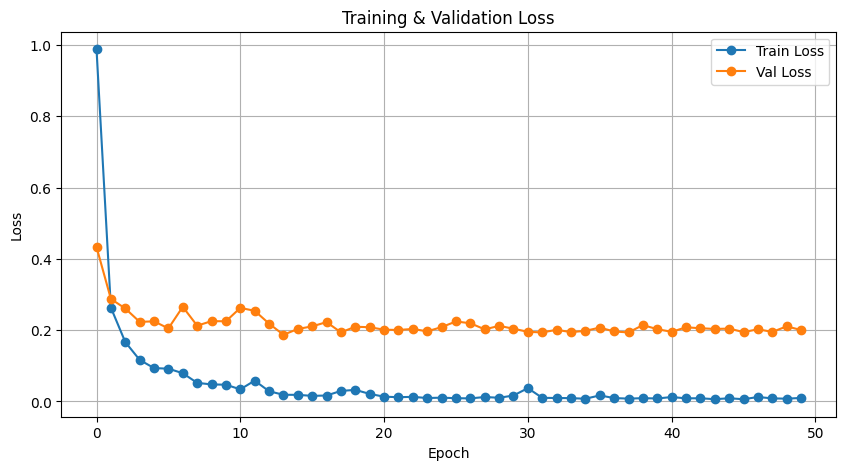

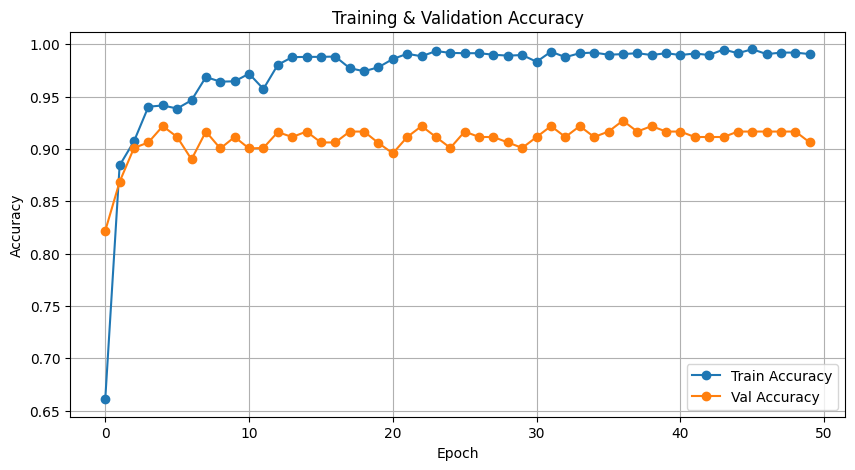

In [28]:
import matplotlib.pyplot as plt


# --- VẼ LOSS ---
plt.figure(figsize=(10,5))
plt.plot(history["train_loss"], label="Train Loss", marker='o')
plt.plot(history["val_loss"], label="Val Loss", marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

# --- VẼ ACCURACY ---
plt.figure(figsize=(10,5))
plt.plot(history["train_acc"], label="Train Accuracy", marker='o')
plt.plot(history["val_acc"], label="Val Accuracy", marker='o')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training & Validation Accuracy")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
MODEL_PATH = "C:\\xlnnkh\\best_resnet1d.pth"       
LABEL_CSV_PATH = "C:\\xlnnkh\\public_label_clean1.csv"  
INPUT_CHANNELS = 126                    
SEQUENCE_LENGTH = 30                   
def load_class_map(csv_path):
    print(f" Đang đọc nhãn từ {csv_path}...")
    try:
        df = pd.read_csv(csv_path)
        unique_labels = sorted(df['label'].unique()) # Sắp xếp A-Z
        label_map = {i: label for i, label in enumerate(unique_labels)}
        print(f" Đã load {len(label_map)} lớp.")
        return label_map
    except:
        return {}

# Load nhãn
CLASS_MAP = load_class_map(LABEL_CSV_PATH)
NUM_CLASSES = len(CLASS_MAP)

# Load Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f" Đang load model lên {device}...")

try:
    model = SimpleCNN(INPUT_CHANNELS, NUM_CLASSES)
    model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
    model.to(device)
    model.eval() # Chế độ dự đoán (tắt dropout)
    print(" Load model thành công!")
except Exception as e:
    print(f" Lỗi load model: {e}")
    exit()

# Khởi tạo MediaPipe
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(
    static_image_mode=False,
    max_num_hands=2,
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5
)

def extract_and_normalize(frame_landmarks):
    coords = []
    for lm in frame_landmarks.landmark:
        coords.extend([lm.x, lm.y, lm.z])
    coords = np.array(coords)
    
    # Dời gốc về cổ tay (như lúc train)
    wrist_x, wrist_y, wrist_z = coords[0], coords[1], coords[2]
    coords_reshaped = coords.reshape(-1, 3)
    coords_reshaped[:, 0] -= wrist_x
    coords_reshaped[:, 1] -= wrist_y
    coords_reshaped[:, 2] -= wrist_z
    
    return coords_reshaped.flatten()


cap = cv2.VideoCapture(0)

# Buffer: Hàng đợi lưu giữ 30 frame gần nhất
# Khi có frame mới, frame cũ nhất tự bị đẩy ra
frames_buffer = deque(maxlen=SEQUENCE_LENGTH)

predicted_label = "Waiting..."
confidence_score = 0.0

print("\n Camera đã bật! Hãy thực hiện hành động...")

while cap.isOpened():
    ret, frame = cap.read()
    if not ret: break
    
    # Lật ảnh soi gương
    frame = cv2.flip(frame, 1)
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = hands.process(rgb)
    
    frame_vector = np.zeros(126) # Mặc định là 0
    has_hand = False
    
    if results.multi_hand_landmarks:
        has_hand = True
        for idx, hand_info in enumerate(results.multi_handedness):
            label = hand_info.classification[0].label 
            landmarks = results.multi_hand_landmarks[idx]
            
            # Chuẩn hóa
            norm_coords = extract_and_normalize(landmarks)
            
            if label == "Left": frame_vector[0:63] = norm_coords
            else: frame_vector[63:126] = norm_coords
            
            # Vẽ
            mp.solutions.drawing_utils.draw_landmarks(frame, landmarks, mp_hands.HAND_CONNECTIONS)

    # Logic: Chỉ đưa vào hàng đợi nếu có tay (hoặc chấp nhận cả frame rỗng nếu muốn liên tục)
    if has_hand:
        frames_buffer.append(frame_vector)
    else:
        # Nếu mất tay, có thể chọn clear buffer hoặc thêm số 0
        # Ở đây mình chọn thêm số 0 để giữ dòng thời gian
        if len(frames_buffer) > 0: # Chỉ thêm nếu đang dở dang
            frames_buffer.append(frame_vector)

    # --- DỰ ĐOÁN (Chỉ khi đủ 30 frame) ---
    if len(frames_buffer) == SEQUENCE_LENGTH:
        # Chuyển buffer thành Tensor: (1, 30, 126)
        input_tensor = torch.tensor(list(frames_buffer), dtype=torch.float32).unsqueeze(0).to(device)
        
        with torch.no_grad():
            outputs = model(input_tensor)
            probs = torch.softmax(outputs, dim=1)
            conf, pred_idx = torch.max(probs, 1)
            
            confidence_score = conf.item() * 100
            
            # Chỉ hiển thị nếu tự tin > 60%
            if confidence_score > 60:
                predicted_label = CLASS_MAP.get(pred_idx.item(), "Unknown")
            else:
                predicted_label = "..."

    # --- HIỂN THỊ KẾT QUẢ ---
    # Vẽ thanh nền
    cv2.rectangle(frame, (0, 0), (640, 80), (0, 0, 0), -1)
    
    # In nhãn
    color = (0, 255, 0) if confidence_score > 80 else (0, 255, 255)
    cv2.putText(frame, f"Action: {predicted_label}", (20, 40), 
                cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2)
    
    # In độ tin cậy
    cv2.putText(frame, f"Conf: {confidence_score:.2f}%", (20, 70), 
                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (200, 200, 200), 1)
    
    # Thanh buffer (cho biết đã thu đủ 30 frame chưa)
    buffer_width = int((len(frames_buffer) / SEQUENCE_LENGTH) * 100)
    cv2.rectangle(frame, (500, 20), (500 + buffer_width, 30), (255, 0, 0), -1)
    cv2.rectangle(frame, (500, 20), (600, 30), (255, 255, 255), 1)

    cv2.imshow("Hand Gesture CNN Real-time", frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

📖 Đang đọc nhãn từ C:\xlnnkh\public_label_clean1.csv...
✅ Đã load 23 lớp.
⏳ Đang load model lên cpu...
✅ Load model thành công!

🚀 Camera đã bật! Hãy thực hiện hành động...
